# RSS default params

alpha_lon_accel_max = 3.5 

alpha_lon_brake_max = 8.0

alpha_lon_brake_min = 4.0

alpha_lon_brake_min_correct = 3.0

alpha_lat_accel_max = 0.2

alpha_lat_brake_min = 0.8

lateral_fluctuation_margin = 0.0

response_time = 1.0

In [1]:
# from sklearn.cluster import KMeans 
import pandas as pd
import os
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.axes3d import Axes3D

import numpy as np
from matplotlib import cm

import csv
import scipy.stats as stats


import sklearn.cluster
from sklearn.mixture import GaussianMixture
from itertools import combinations
import math

from sklearn.neighbors import KernelDensity

from sklearn import preprocessing

# for interactive plots
%matplotlib inline

# Setting and read all data

In [2]:
#### Names
scenario_names = ['LVM1', 'LVM2', 'LVD', 'LVDAD', 'POV_UnprotectedLeft', 'OppositeVehicleRunningRedLight', 'all']

X1_name = 'alpha_lon_accel_max'
X2_name = 'alpha_lon_brake_max'
X3_name = 'alpha_lon_brake_min'
X4_name = 'response_time'
X5_name = 'alpha_lat_accel_max'
X6_name = 'alpha_lat_brake_min'
X7_name = 'lateral_fluctuation_margin'
X8_name = 'alpha_lon_brake_min_correct'
rob = 'robustness'

var_names = [rob, X1_name, X2_name, X3_name, X4_name, X5_name, X6_name, X7_name, X8_name]
var_units = ['m', 'm/s^2','m/s^2', 'm/s^2', 's', 'm/s^2', 'm/s^2', 'm', 'm/s^2']

## concat all data
data_concat = pd.DataFrame()
data_all = []

##########################################
## whether to check collision data points or not

check_collision = 0

##########################################

for sce in scenario_names[:-1]:
    scenario = sce
    print(scenario)
    res_path = "../../results/"+scenario
    
    data_aux = pd.read_csv(os.path.join(res_path, scenario + '_combined.csv'), index_col=False)
    data_aux = data_aux.dropna()
    
#     if scenario == "OppositeVehicleRunningRedLight":
#         data_aux[X8_name] = 2.0
#     if scenario in scenario_names[:4]:
#         print(scenario)
#         data_aux[X5_name] = 0.2
#         data_aux[X6_name] = 0.8
#         data_aux[X7_name] = 0.0
#         data_aux[X8_name] = 2.0
    
    data_collision = data_aux.loc[data_aux[rob] < 0.15]
    data_no_collision = data_aux.loc[data_aux[rob] >= 0.15]
    
    if check_collision:
        data_ = data_collision
    else:
        data_ = data_no_collision
    
    print(data_.shape)
    data_all.append(data_)
    
    data_concat = pd.concat([data_concat, data_], ignore_index=True, sort=False)

if check_collision:
    data_concat.to_csv("../../results/all_combined_collision.csv", index=False)
else:
    data_concat.to_csv("../../results/all_combined_no_collision.csv", index=False)

data_all.append(data_concat)
print(len(data_all))

LVM1
(5829, 9)
LVM2
(3932, 9)
LVD
(3000, 9)
LVDAD
(11806, 9)
POV_UnprotectedLeft
(9000, 9)
OppositeVehicleRunningRedLight
(6001, 9)
7


#### normalize robustness data

In [ ]:
# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

X = np.array(data_concat[rob]).reshape(-1, 1)

# Plot the dataframe
# (data_concat[rob]).plot(kind='bar')

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(X)

# Run the normalizer on the dataframe
rob_normalized = pd.DataFrame(x_scaled)

data_concat['robustness'] = rob_normalized

data_all.append(data_concat)

#### Run kmeans and get clusters

LVM1
LVM2
LVD
LVDAD
POV_UnprotectedLeft
OppositeVehicleRunningRedLight
all
saving centroids to ../../results/all_centroid.csv
Saving labels to ../../results/all_param_cluster.csv
points in cluster 0 33437
points in cluster 1 3914
 
saving centroids to ../../results/global_centroids.csv


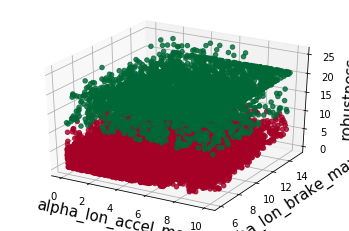

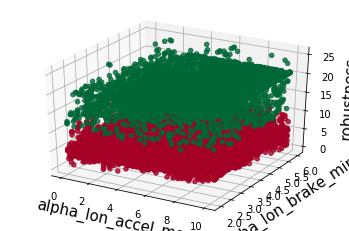

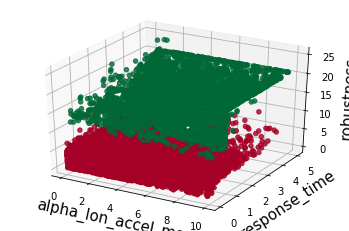

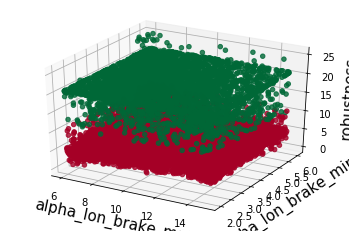

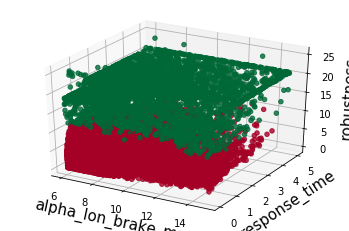

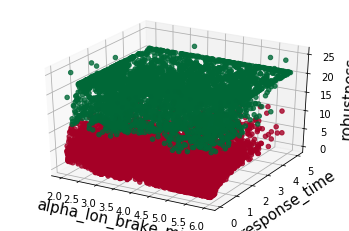

In [19]:
lat_flag = -1
all_flag = -1

if check_collision:
    fn_centroids_all_scenarios = os.path.join("../../results/", 'collision_global_centroids.csv')
else:
    fn_centroids_all_scenarios = os.path.join("../../results/", 'global_centroids.csv')
      

centroids_df = pd.DataFrame()

centroids_all = []
data_post_proc = []

for i, data_ in enumerate(data_all):
    
    scenario = scenario_names[i]
    data_ = data_.loc[data_['robustness'] <= 25.0]
    
    if scenario == 'all':
        res_path = "../../results/"
    else:
        res_path = "../../results/"+scenario
    
    var_names = [rob, X1_name, X2_name, X3_name, X4_name, X5_name, X6_name, X7_name, X8_name]
    
#     if scenario == 'OppositeVehicleRunningRedLight' :
#         lat_flag = 1
#         var_names = [rob, X1_name, X2_name, X3_name, X4_name, X5_name, X6_name, X7_name, X8_name]
#     elif scenario == 'POV_UnprotectedLeft' or scenario == 'all':
#         all_flag = 1
#         var_names = [rob, X1_name, X2_name, X3_name, X4_name, X5_name, X6_name, X7_name, X8_name]
#     else:
#         lat_flag = 0
#         var_names = [rob, X1_name, X2_name, X3_name, X4_name]

    print(scenario)
#     print(data_)
    
    scenario_fn = scenario
    
    data_ = data_.sort_values(rob)
    if check_collision:
        data = data_
        scenario_fn = scenario + '_collision'

        if scenario == 'all':
            file_name = os.path.join(res_path, scenario_fn + '_combined.csv')
            data.to_csv(file_name, index=False)
        
        clusters = 1
    else:
        data = data_
        clusters = 2
    
    data_desc = data.describe()
    file_name = os.path.join(res_path, scenario_fn + '_desc.csv')
#     fh = open(file_name, 'w')
#     data_desc.to_csv(file_name, index=True)

    min_params = data.iloc[0]
    max_params = data.iloc[-1]
    
    pd.concat([min_params, max_params], axis=1).to_csv(file_name, index=True)
    
    if scenario == 'all':
        ###################################### Run Kmeans
#         data = data.reset_index()[var_names[1:]]
        
        model = sklearn.cluster.KMeans(n_clusters = clusters, n_jobs = 4)
        labels = model.fit_predict(data)
        centroids = model.cluster_centers_
        
        ###################################### concat all scenarios centroids
        centroids_aux = centroids.tolist()
        
        df = pd.DataFrame(centroids_aux, columns = var_names)
        df['scenario'] = [scenario]*clusters
        centroids_df = pd.concat([centroids_df, df], ignore_index=True, sort=False)
        
        ###################################### Save centorids to file
        file_name = os.path.join(res_path, scenario_fn + '_centroid.csv')
        print("saving centroids to", file_name)
        
        res = [var_names] + centroids_aux
        with open(file_name, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(res)

        ###################################### save data with clusters labels
        file_name = os.path.join(res_path, scenario_fn + '_param_cluster.csv')
        print('Saving labels to', file_name)
        data['cluster_label'] = labels 
        data.to_csv(file_name, index=False)
        data_post_proc.append(data)
        
        for clus in range(0, clusters):
            print('points in cluster', clus, len(data[:][data['cluster_label'] == clus]))
        
        ###################################### save description of clustered data
        df_desc_concat = pd.DataFrame()
        for cl in range(0,clusters):
            df_desc = data.loc[data['cluster_label'] == cl].describe()
            df_desc_concat = pd.concat([df_desc_concat, df_desc])
        
        file_name = os.path.join(res_path, scenario_fn + '_cluster_desc.csv')
        df_desc_concat.to_csv(file_name, index=True)


        ###################################### Plot 3D graphs        
        #### Run combination of var for plotting
        comb_names = combinations([X1_name, X2_name, X3_name, X4_name], 2) 
        names_list = list(comb_names)

        R = data[rob]

        ### create plots
        for i, var in enumerate(names_list):
            search_name_x = names_list[i][0]
            search_name_y = names_list[i][1]

            X1 = data[search_name_x]
            X2 = data[search_name_y]

            ## Plot data
            fig = plt.figure(i)
            ax = plt.axes(projection='3d')    

            ax.scatter3D(X1, X2, R, c=labels, cmap=cm.RdYlGn, alpha=0.8)
            ax.set_xlabel(search_name_x, fontsize=15)
            ax.set_ylabel(search_name_y, fontsize=15)
            ax.set_zlabel(rob, fontsize=15)
            plt.tick_params(labelsize=10) 

#             figname = os.path.join(res_path, scenario_fn + '_kmeans_' +  search_name_x + '_vs_' + search_name_y + '.pdf')
#             plt.savefig(figname, dpi=200)
        
        print(' ')
            

# plt.show()
###################################### save all scnearios centroids to file
print("saving centroids to", fn_centroids_all_scenarios)
centroids_df.to_csv(fn_centroids_all_scenarios, index=True)


#### Boxplots with centroids

#############################################
scenario: LVM1
alpha_lon_accel_max [1.3319781561156092, 1.3319781561156092]
alpha_lon_brake_max [6.738043280989787, 6.738043280989787]
alpha_lon_brake_min [3.909598390372692, 3.909598390372692]
response_time [0.27863506083905365, 0.27863506083905365]


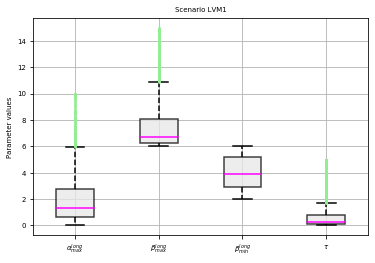

#############################################
scenario: LVM2
alpha_lon_accel_max [3.175943073068659, 3.175943073068659]
alpha_lon_brake_max [7.240360987626862, 7.240360987626862]
alpha_lon_brake_min [5.526103176788149, 5.526103176788149]
response_time [0.2940175385226027, 0.2940175385226027]


<Figure size 432x288 with 0 Axes>

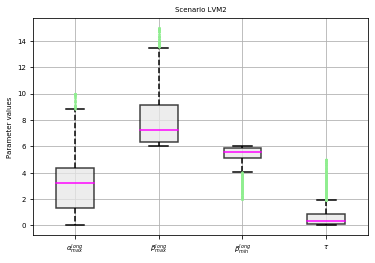

#############################################
scenario: LVD
alpha_lon_accel_max [7.71664502592427, 7.71664502592427]
alpha_lon_brake_max [9.364142832549593, 9.364142832549593]
alpha_lon_brake_min [3.5671743138438354, 3.5671743138438354]
response_time [0.5318833971313968, 0.5318833971313968]


<Figure size 432x288 with 0 Axes>

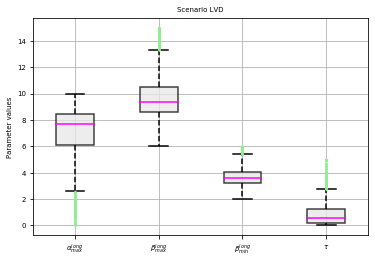

#############################################
scenario: LVDAD
alpha_lon_accel_max [3.5356423726287405, 3.5356423726287405]
alpha_lon_brake_max [7.826391151048217, 7.826391151048217]
alpha_lon_brake_min [5.389630701460025, 5.389630701460025]
response_time [0.2434743103348679, 0.2434743103348679]


<Figure size 432x288 with 0 Axes>

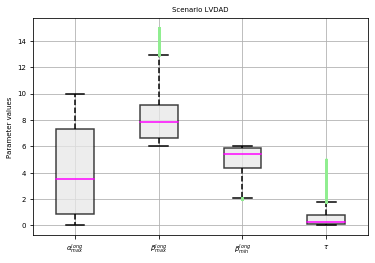

#############################################
scenario: POV_UnprotectedLeft
alpha_lon_accel_max [6.228967876423121, 6.228967876423121]
alpha_lon_brake_max [6.755508355905567, 6.755508355905567]
alpha_lon_brake_min [4.5405892175030305, 4.5405892175030305]
response_time [0.7609506454292024, 0.7609506454292024]
alpha_lat_accel_max [0.7911226836252204, 0.7911226836252204]
alpha_lat_brake_min [1.646015752157442, 1.646015752157442]
lateral_fluctuation_margin [0.20670002671855242, 0.20670002671855242]
alpha_lon_brake_min_correct [1.151849678560248, 1.151849678560248]


<Figure size 432x288 with 0 Axes>

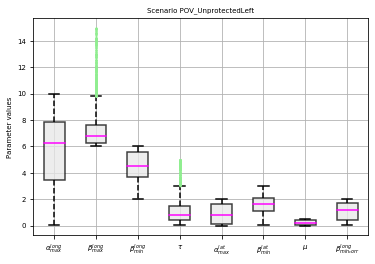

#############################################
scenario: OppositeVehicleRunningRedLight
alpha_lon_accel_max [5.327580200036658, 5.327580200036658]
alpha_lon_brake_max [11.351007829400995, 11.351007829400995]
alpha_lon_brake_min [4.229820648178002, 4.229820648178002]
response_time [0.2474917674602622, 0.2474917674602622]
alpha_lat_accel_max [0.7738936720849777, 0.7738936720849777]
alpha_lat_brake_min [0.5266290017068109, 0.5266290017068109]
lateral_fluctuation_margin [0.17718560354720628, 0.17718560354720628]


<Figure size 432x288 with 0 Axes>

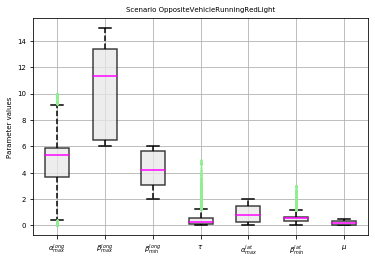

#############################################
scenario: all
alpha_lon_accel_max [4.0503580195642055, 4.0503580195642055]
alpha_lon_brake_max [7.375383842245561, 7.375383842245561]
alpha_lon_brake_min [4.841661117910089, 4.841661117910089]
response_time [0.38314709202564695, 0.38314709202564695]
alpha_lat_accel_max [0.2, 0.2]
alpha_lat_brake_min [0.8, 0.8]
lateral_fluctuation_margin [0.0, 0.0]
alpha_lon_brake_min_correct [3.0, 3.0]


<Figure size 432x288 with 0 Axes>

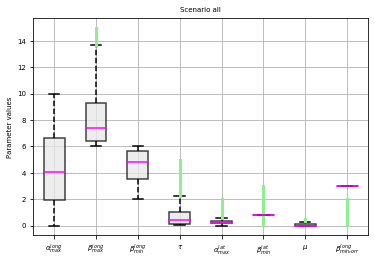

<Figure size 432x288 with 0 Axes>

In [40]:
# var_names_with_units = [rob, 'long accel max*', 'long brake max*', 'long brake min*', 'response time**', 
#                         'lat accel max*', 'lat_brake_min*', 'lat fluctuation', 'lon brake min corr*']
# var_names = [rob, X1_name, X2_name, X3_name, X4_name, X5_name, X6_name, X7_name, X8_name]
rotation = 0
label_size = 7

for sce in scenario_names:
    scenario = sce
    sce_index = scenario_names.index(scenario)
    
    var_names_with_units = [r'$\rho_\varphi$', r'$\alpha^{long}_{max}$', r'$\beta^{long}_{max}$', r'$\beta^{long}_{min}$', r'$\tau$',
                        r'$\alpha^{lat}_{max}$', r'$\beta^{lat}_{min}$', r'$\mu$', r'$\beta^{long}_{min_corr}$']
    var_names = [rob, X1_name, X2_name, X3_name, X4_name, X5_name, X6_name, X7_name, X8_name]
    
    if scenario == 'all':
        res_path = "../../results/"
    else:
        res_path = "../../results/"+scenario
    
    if scenario == 'OppositeVehicleRunningRedLight':
        var_names = [rob, X1_name, X2_name, X3_name, X4_name, X5_name, X6_name, X7_name]
        var_names_with_units = var_names_with_units[:len(var_names)]
        
    if scenario in scenario_names[:4]:
        var_names = [rob, X1_name, X2_name, X3_name, X4_name]
        var_names_with_units = var_names_with_units[:len(var_names)]
        
        
    data = data_all[sce_index]

    
    print('#############################################')
    print('scenario:', scenario)

#     fig, ax1 = plt.subplots(figsize=(8,6))
    fig, ax1 = plt.subplots()
    

#     ax1.set_ylabel('Parameter values - * [m/s^2], ** [s], ^[m]', fontsize = label_size)  
    ax1.set_ylabel('Parameter values', fontsize = label_size)  
    
    ax1.grid(zorder = 1)
    ax1.tick_params(labelsize = label_size)
    ax1.tick_params(axis='x', rotation=rotation)

    
    ##########################################
    ### Box plot
    flierprops = dict(markerfacecolor='#90ee90',
                      marker='o', 
                      alpha=0.75, 
                      markersize=2,
                      markeredgecolor='none')
    medianprops = dict(linestyle='-', 
                       linewidth=1.5, 
                       color='magenta')
    boxprops = dict(linestyle='-', 
                    linewidth=1.5, 
                    color='k', 
                    facecolor='#E8E8E8', 
                    alpha=0.75)
    whiskerprops = dict(linestyle='--', 
                        linewidth=1.5, 
                        color='k')
    capprops = dict(linestyle='-', 
                    linewidth=1.5, 
                    color='k')
    
    box_plot_desc = ax1.boxplot([data[col] for col in data if col in var_names[1:]], 
                labels=var_names_with_units[1:], 
                boxprops = boxprops,
                capprops = capprops,
                medianprops = medianprops, 
                flierprops = flierprops, 
                whiskerprops = whiskerprops,
                patch_artist = True,
                zorder = 2)
    
    ##################################
    ### For printin medians
    
    num_boxes = len(var_names[1:])
    medians = np.empty(num_boxes)
    
    for k in range(num_boxes):
        med = box_plot_desc['medians'][k]
        medianX = []
        medianY = []
        for j in range(2):
            medianX.append(med.get_xdata()[j])
            medianY.append(med.get_ydata()[j])
        print(var_names[k+1], medianY)
    ##################################
    
    
#     ax1.tick_params(labelsize = label_size)
    ax1.set_title('Scenario ' + scenario, fontsize = label_size)
    plot_markers = ['rs-.', 'bv:', 'yo-.', 'g+--'] # per cluster
    color = ['red', 'blue']
    
    if check_collision == 0 and scenario == 'kk_all':
        ax2 = ax1.twinx()
        ax2.set_ylabel('Robustness [m]', fontsize = label_size)  # we already handled the x-label with ax1
        ax2.tick_params(axis='y', labelsize = label_size)
    
        ##### clusters plot
        
        if scenario =='all':
            x = np.array(range(1,len(var_names[1:])+1))
            for i in range(0, clusters):

                data_clusters = data.loc[data['cluster_label'] == i]
                cluster_desc = data_clusters.describe()
                if check_collision:
                    cluster_desc.to_csv(os.path.join(res_path, scenario + '_' + str(i) + '_cluster_desc_collision.csv'), index=True)
                else:
                    cluster_desc.to_csv(os.path.join(res_path, scenario + '_' + str(i) + '_cluster_desc_no_collision.csv'), index=True)

                data_desc = data_clusters.describe()
                y = data_desc.loc['mean']
                std = data_desc.loc['std']

                y = y.tolist()
                y_ = np.array(y)

                std = std.tolist()
                std_ = np.array(std)

                rob_y = y_[0]
                rob_std = std_[0]
                rob_x = [len(var_names[1:])+1]
                ax2.axis([0,len(var_names[1:])+1, 0, 22])
                
                ax2.errorbar(rob_x, y=rob_y, yerr=rob_std, fmt=plot_markers[i],linewidth=3,
                             markersize=3, capsize=3, zorder=20, clip_on=False)


                ax1.errorbar(x, y_[1:-1], yerr=std_[1:-1], fmt=plot_markers[i], capsize=3,
                             markersize=3, clip_on=False, label="cluster {0}, robustness: {1:.1f}".format(i+1, y[0]), zorder=10)
                ax1.legend(loc='upper right', fontsize=label_size)

    if check_collision:
        figname = os.path.join(res_path, scenario + '_boxplot_collision.pdf')
    else:
        figname = os.path.join(res_path, scenario + '_boxplot_no_collision.pdf')
    
    plt.savefig(figname, dpi=200, bbox_inches='tight')
    plt.show()
    plt.tight_layout()
    


#### Boxplot lat and long separated

#############################################
scenario: POV_UnprotectedLeft


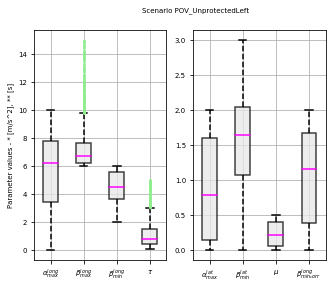

#############################################
scenario: OppositeVehicleRunningRedLight


<Figure size 432x288 with 0 Axes>

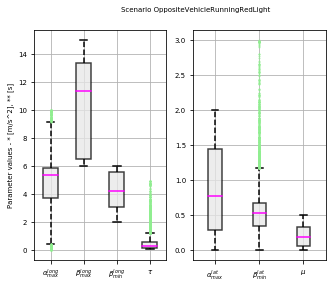

#############################################
scenario: all


<Figure size 432x288 with 0 Axes>

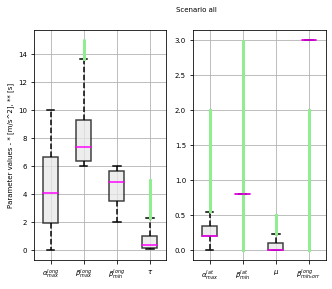

<Figure size 432x288 with 0 Axes>

In [41]:
scenario_names_ = scenario_names[4:]
# label_size = 7

for sce in scenario_names_:
    scenario = sce
    sce_index = scenario_names.index(scenario)
    
    var_names_with_units = [r'$\rho_\varphi$', r'$\alpha^{long}_{max}$', r'$\beta^{long}_{max}$', r'$\beta^{long}_{min}$', r'$\tau$',
                        r'$\alpha^{lat}_{max}$', r'$\beta^{lat}_{min}$', r'$\mu$', r'$\beta^{long}_{min_corr}$']
    var_names = [rob, X1_name, X2_name, X3_name, X4_name, X5_name, X6_name, X7_name, X8_name]
    
    if scenario == 'all':
        res_path = "../../results/"
    else:
        res_path = "../../results/"+scenario
    
    if scenario == 'OppositeVehicleRunningRedLight':
        var_names = [rob, X1_name, X2_name, X3_name, X4_name, X5_name, X6_name, X7_name]
        var_names_with_units = var_names_with_units[:len(var_names)]
        
    if scenario in scenario_names[:4]:
        var_names = [rob, X1_name, X2_name, X3_name, X4_name]
        var_names_with_units = var_names_with_units[:len(var_names)]
        label_size = 7
        
    data = data_all[sce_index]

    
    print('#############################################')
    print('scenario:', scenario)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Scenario ' + scenario, fontsize = label_size)

    ax1.set_ylabel('Parameter values - * [m/s^2], ** [s]', fontsize = label_size)  
    ax1.grid(zorder = 1)
    ax1.tick_params(labelsize = label_size)
    ax1.tick_params(axis='x', rotation=rotation)
    
    ax2.grid(zorder = 1)
    ax2.tick_params(labelsize = label_size)
    ax2.tick_params(axis='x', rotation=rotation)
    
    
    ##########################################
    ### Box plot
    flierprops = dict(markerfacecolor='#90ee90',
                      marker='o', 
                      alpha=0.75, 
                      markersize=2,
                      markeredgecolor='none')
    medianprops = dict(linestyle='-', 
                       linewidth=1.5, 
                       color='magenta')
    boxprops = dict(linestyle='-', 
                    linewidth=1.5, 
                    color='k', 
                    facecolor='#E8E8E8', 
                    alpha=0.75)
    whiskerprops = dict(linestyle='--', 
                        linewidth=1.5, 
                        color='k')
    capprops = dict(linestyle='-', 
                    linewidth=1.5, 
                    color='k')
    
    #### Longitudinal
    box_plot_desc = ax1.boxplot([data[col] for col in data if col in var_names[1:5]], 
                labels=var_names_with_units[1:5], 
                boxprops = boxprops,
                capprops = capprops,
                medianprops = medianprops, 
                flierprops = flierprops, 
                whiskerprops = whiskerprops,
                patch_artist = True,
                showfliers=True,
                zorder = 2)
    
    
    ### Lateral
    box_plot_desc = ax2.boxplot([data[col] for col in data if col in var_names[5:]], 
                labels=var_names_with_units[5:], 
                boxprops = boxprops,
                capprops = capprops,
                medianprops = medianprops, 
                flierprops = flierprops, 
                whiskerprops = whiskerprops,
                patch_artist = True,
                showfliers=True,
                zorder = 2)

    plot_markers = ['rs-.', 'bv:', 'yo-.', 'g+--'] # per cluster
    color = ['red', 'blue']
    
    if check_collision == 0 and scenario == 'kk_all':
        ax3 = ax2.twinx()
        ax3.set_ylabel('Robustness [m]', fontsize = label_size)  # we already handled the x-label with ax1
        ax3.tick_params(axis='y', labelsize = label_size)
    
        ##### clusters plot
        
        if scenario =='all':
            x = np.array(range(1,len(var_names[1:5])+1))
            
            for i in range(0, clusters):

                data_clusters = data.loc[data['cluster_label'] == i]
                cluster_desc = data_clusters.describe()
                if check_collision:
                    cluster_desc.to_csv(os.path.join(res_path, scenario + '_' + str(i) + 'lat_cluster_desc_collision.csv'), index=True)
                else:
                    cluster_desc.to_csv(os.path.join(res_path, scenario + '_' + str(i) + 'lat_cluster_desc_no_collision.csv'), index=True)

                data_desc = data_clusters.describe()
                y = data_desc.loc['mean']
                std = data_desc.loc['std']

                y = y.tolist()
                y_ = np.array(y)
                
                std = std.tolist()
                std_ = np.array(std)

                rob_y = y_[0]
                rob_std = std_[0]
                rob_x = [len(var_names[1:5])+1]
                
                ax3.axis([0,len(var_names[1:5])+1, 0, 22])
                
                ax3.errorbar(rob_x, y=rob_y, yerr=rob_std, fmt=plot_markers[i], linewidth=3, 
                             markersize=3, capsize=3, zorder=20, clip_on=False)

            
                ax1.errorbar(x, y_[1:5], yerr=std_[1:5], fmt=plot_markers[i], capsize=3,
                             markersize=3, clip_on=False, label="cluster {0}, robustness: {1:.1f}".format(i+1, y[0]), zorder=10)
                
                ax1.legend(loc='upper left', fontsize = label_size)

                x = np.array(range(1,len(var_names[5:])+1))
                ax2.errorbar(x, y_[5:-1], yerr=std_[5:-1], fmt=plot_markers[i], capsize=3,
                             markersize=3, clip_on=False, label="cluster {0}, robustness: {1:.1f}".format(i+1, y[0]), zorder=10)

                ax2.legend(loc = 'upper left', fontsize = label_size)

                
    if check_collision:
        figname = os.path.join(res_path, scenario + '_boxplot_collision_lat_long.pdf')
    else:
        figname = os.path.join(res_path, scenario + '_boxplot_no_collision_lat_long.pdf')
    
#     plt.xticks(rotation=10)
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    plt.savefig(figname, dpi=200, bbox_inches='tight')
    plt.show()

    
    plt.tight_layout(pad=10.0)
    


#### lat long clusters separately

['robustness', 'alpha_lon_accel_max', 'alpha_lon_brake_max', 'alpha_lon_brake_min', 'response_time']
[[ 4.01632226  4.10280633  8.02809349  4.64212157  0.53695528]
 [18.50107287  5.94719147  9.54185868  4.12944716  1.92872771]]
saving centroids to ../../results/all_long_centroids.csv
Saving labels to ../../results/all_long_param_cluster.csv
points in cluster 0 33437
points in cluster 1 3914
[1 2 3 4] [4.10280633 8.02809349 4.64212157 0.53695528]
[1 2 3 4] [5.94719147 9.54185868 4.12944716 1.92872771]
['robustness', 'alpha_lat_accel_max', 'alpha_lat_brake_min', 'lateral_fluctuation_margin', 'alpha_lon_brake_min_correct']
[[ 4.99079952  0.84660506  1.25525796  0.2151227   1.70052604]
 [17.46978218  1.13191185  1.03476049  0.26948494  1.90345513]]
saving centroids to ../../results/all_lat_centroids.csv
Saving labels to ../../results/all_lat_param_cluster.csv
points in cluster 0 12368
points in cluster 1 1118
[1 2 3 4] [0.84660506 1.25525796 0.2151227  1.70052604]
[1 2 3 4] [1.13191185 1.0

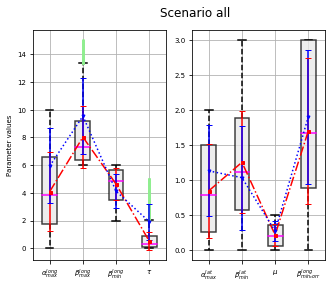

<Figure size 432x288 with 0 Axes>

In [42]:

# label_size = 7
# var_names_with_units = [rob, 'long accel max*', 'long brake max*', 'long brake min*', 'response time**', 
#                     'lat accel max*', 'lat_brake_min*', 'lat fluctuation^', 'lon brake min corr*']

var_names_with_units = [r'$\rho_\varphi$', r'$\alpha^{long}_{max}$', r'$\beta^{long}_{max}$', r'$\beta^{long}_{min}$', r'$\tau$',
                        r'$\alpha^{lat}_{max}$', r'$\beta^{lat}_{min}$', r'$\mu$', r'$\beta^{long}_{min_corr}$']
var_names = [rob, X1_name, X2_name, X3_name, X4_name, X5_name, X6_name, X7_name, X8_name]
    
data_long = data_all[-1]
data_long = data_long.loc[data_long['robustness'] <= 25.0]

var_names_ = var_names[:5]
data_long = data_long[var_names_]
# print(data_long)

data_lat = pd.concat([data_all[-2], data_all[-3]], ignore_index=True, sort=False)
data_lat = data_lat.loc[data_lat['robustness'] <= 25.0]

var_names_ = ['robustness'] +var_names[5:]
data_lat = data_lat[var_names_]

# print(data_lat)

res_path = "../../results/"
scenario_fn = 'all'

fig, ax = plt.subplots(1, 2)
fig.suptitle('Scenario ' + scenario)

# ax[0].set_ylabel('Parameter values - *' + r'$[m/s^2]$' + '**' + r'$[s]$', fontsize = label_size)  
ax[0].set_ylabel('Parameter values', fontsize = label_size)  

ax[0].grid(zorder = 1)
ax[0].tick_params(labelsize = label_size)
ax[0].tick_params(axis='x', rotation=0)

ax[1].grid(zorder = 1)
ax[1].tick_params(labelsize = label_size)
ax[1].tick_params(axis='x', rotation=0)

ax[0].grid(zorder = 1)
ax[1].grid(zorder = 1)

#### Longitudinal
box_plot_desc = ax[0].boxplot([data_long[col] for col in data_long if col in var_names[1:5]], 
            labels=var_names_with_units[1:5], 
            boxprops = boxprops,
            capprops = capprops,
            medianprops = medianprops, 
            flierprops = flierprops, 
            whiskerprops = whiskerprops,
            patch_artist = True,
            showfliers=True,
            zorder = 2)


### Lateral
box_plot_desc = ax[1].boxplot([data_lat[col] for col in data_lat if col in var_names[5:]], 
            labels=var_names_with_units[5:], 
            boxprops = boxprops,
            capprops = capprops,
            medianprops = medianprops, 
            flierprops = flierprops, 
            whiskerprops = whiskerprops,
            patch_artist = True,
            showfliers=True,
            zorder = 2)

# #####################################################
# #### Lateral clusters
 
for i, data_aux in enumerate([data_long, data_lat]):
    ###################################### Run Kmeans
#         data = data.reset_index()[var_names[1:]]

    if i == 0:
        var_names_ = var_names[:5]
        scene = 'long'
    else: 
        var_names_ = ['robustness'] +var_names[5:]
        scene = 'lat'
        
    model = sklearn.cluster.KMeans(n_clusters = clusters, n_jobs = 4)
    labels = model.fit_predict(data_aux[var_names_])
    centroids = model.cluster_centers_
    print(var_names_)
    print(centroids)

    ###################################### concat all scenarios centroids
    centroids_aux = centroids.tolist()

    df = pd.DataFrame(centroids_aux, columns = var_names_)
    df['scenario'] = [scenario]*clusters
    centroids_df = pd.concat([centroids_df, df], ignore_index=True, sort=False)

    ###################################### Save centorids to file
    file_name = os.path.join(res_path,  scenario_fn + '_' + scene +'_centroids.csv')
    print("saving centroids to", file_name)

    res = [var_names] + centroids_aux
    with open(file_name, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(res)

    ###################################### save data with clusters labels
    file_name = os.path.join(res_path, scenario_fn + '_' + scene + '_param_cluster.csv')
    print('Saving labels to', file_name)
    data_aux['cluster_label'] = labels 
    data_aux.to_csv(file_name, index=False)
    data_post_proc.append(data_aux)

    for clus in range(0, clusters):
        print('points in cluster', clus, len(data_aux[:][data_aux['cluster_label'] == clus]))

    ###################################### save description of clustered data
    df_desc_concat = pd.DataFrame()
    for cl in range(0,clusters):
        df_desc = data_aux.loc[data_aux['cluster_label'] == cl].describe()
        df_desc_concat = pd.concat([df_desc_concat, df_desc])

    file_name = os.path.join(res_path, scenario_fn + '_' + scene +'_cluster_desc.csv')
    df_desc_concat.to_csv(file_name, index=True)
    
    
    plot_markers = ['rs-.', 'bv:', 'yo-.', 'g+--'] # per cluster
    color = ['red', 'blue']

    # if check_collision == 0 and scenario == 'all':
#     ax3 = ax[1].twinx()
#     ax3.set_ylabel('Robustness', fontsize = label_size)  # we already handled the x-label with ax1
#     ax3.tick_params(axis='y', labelsize = label_size)

    

    for j in range(0, clusters):

        data_clusters = data_aux.loc[data_aux['cluster_label'] == j]
        cluster_desc = data_clusters.describe()

        if check_collision:
            cluster_desc.to_csv(os.path.join(res_path, scenario + '_' + str(j) + '_cluster_desc_collision.csv'), index=True)
        else:
            cluster_desc.to_csv(os.path.join(res_path, scenario + '_' + str(j) + '_cluster_desc_no_collision.csv'), index=True)

        y = cluster_desc.loc['mean']
        std = cluster_desc.loc['std']

        y = y.tolist()[:-1]
        y_ = np.array(y)

        std = std.tolist()[:-1]
        std_ = np.array(std)

        rob_y = y_[0]
        rob_std = std_[0]
        rob_x = [len(var_names_)]

#         ax3.axis([0,len(var_names_), 0, 25])

#         ax3.errorbar(rob_x, y=rob_y, yerr=rob_std, fmt=plot_markers[j], linewidth=3, 
#                      markersize=3, capsize=3, zorder=20, clip_on=False)

        if i == 0:
            x = np.array(range(1,len(var_names[1:5])+1))
            
            print(x, y_[1:])
            ax[0].errorbar(x, y_[1:], yerr=std_[1:], fmt=plot_markers[j], capsize=3,
                         markersize=3, clip_on=False, zorder=10)
                           #label="cluster {0}, robustness: {1:.1f}".format(i+1, y[0]), zorder=10)

#             ax[0].legend(loc='upper left', fontsize = label_size)
        else:
            x = np.array(range(1,len(var_names_)))
            print(x, y_[1:])
            ax[1].errorbar(x, y_[1:], yerr=std_[1:], fmt=plot_markers[j], capsize=3,
                         markersize=3, clip_on=False, zorder=10)
                           #label="cluster {0}, robustness: {1:.1f}".format(i+1, y[0]), zorder=10)

#             ax[1].legend(loc = 'upper left', fontsize = label_size)

figname = os.path.join(res_path, scenario + '_boxplot_no_collision_lat_long.pdf')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.savefig(figname, dpi=200, bbox_inches='tight')
plt.show()

plt.tight_layout(pad=10.0)
plt.show()

#### Kernel Density Estimation
https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html#sphx-glr-auto-examples-neighbors-plot-kde-1d-py

In [ ]:
samples = data_no_collision
var_names = [X1_name, X2_name, X3_name, X4_name, X5_name, X6_name, X7_name] #, X8_name]

for i, var in enumerate(var_names):
    print(var)
    X = samples[var].dropna()
    X = np.array(X)
    if X.shape[0] > 0:
        print(X.shape)

        X = X.reshape(-1, 1)
        N = X.shape[0]

        kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)

        max_point = X.max()
        
        X_plot = np.linspace(0, max_point, 3000)[:, None]

        log_dens = kde.score_samples(X_plot)
        
        fig = plt.figure(i, figsize=(7,4))
        ax = fig.subplots()
        ax.plot(X_plot[:, 0], np.exp(log_dens), color = 'black', linestyle='-', label="KDE {0}, {1} pts".format(var, N))

        ax.legend(loc='upper right')        
        ax.set_xlabel(var + ' [' + var_units[i] + ']', fontsize=10)
        ax.set_ylabel('Density', fontsize=10)

        if check_collision:
            figname = os.path.join("../../results", 'all_collision_kde_' +  var + '.pdf')
        else:
            figname = os.path.join("../../results", 'all_no_collision_kde_' +  var + '.pdf')
                
        plt.savefig(figname, dpi=200)
        
#         plt.show()
    else: 
        print(var, 'no collision')

# Experimental

In [ ]:
data = data_concat.sort_values('robustness')
min_params = data.iloc[0]
max_params = data.iloc[-1]
median_params = data.iloc[int(data.shape[0]/2)]
#     mean_params = data.loc[data['robustness'] == mean]
var_names = [rob, X1_name, X2_name, X3_name, X4_name]

print("min robustness")
print(min_params)
print("max robustness")
print(max_params)
print("median robustness")
print(median_params)

fig, ax1 = plt.subplots(figsize=(6,10))
data.loc[:, [X1_name, X2_name, X3_name, X4_name]].boxplot(rot=45)
ax2 = ax1.twinx()
ax2.set_ylabel('Robustness normalized')

        
#     ########### min max and median
ax1.plot(list(range(1, len(var_names[1:])+1)), max_params[1:], '*c--', label="max robustness: {0:.3f}".format(max_params[0]))
ax1.legend(loc='upper right')

# ax1.plot(list(range(1, len(var_names[1:])+1)), median_params[1:], 'sr-', label="median robustness: {0:.3f}".format(median_params[0]))
# ax1.legend(loc='upper right')

ax1.plot(list(range(1, len(var_names[1:])+1)), min_params[1:], 'vm-.', label="min robustness: {0:.3f}".format(min_params[0]))
ax1.legend(loc='upper right')

res_path = "../../results/"
if check_collision:
    figname = os.path.join(res_path, "longitudinal_all" + '_boxplot_collision.pdf')
else:
    figname = os.path.join(res_path, "longitudinal_all" + '_boxplot_no_collision.pdf')
    
plt.savefig(figname, dpi=200)


In [ ]:
import numpy as np
from sklearn.manifold import TSNE
X = np.array(data_concat)
X_embedded = TSNE(n_components=3, perplexity=30, init='pca', n_iter_without_progress=100).fit_transform(X)
print(X_embedded.shape)

In [ ]:
scenario_names = ['LVM1', 'LVM2', 'LVDAD', 'LVD', 'POV_UnprotectedLeft']
scenario = scenario_names[1]
# print(scenario)
#
res_path = "../../results/"+scenario

X1_name = 'alpha_lon_accel_max'
X2_name = 'alpha_lon_brake_max'
X3_name = 'alpha_lon_brake_min'
X4_name = 'response_time'

# Read data from a csv to pandas data frame
data = pd.read_csv(os.path.join(res_path, scenario + '_combined.csv'), index_col=False)

In [ ]:
from matplotlib.text import Annotation
from mpl_toolkits.mplot3d.proj3d import proj_transform

class Annotation3D(Annotation):
    def __init__(self, text, xyz, *args, **kwargs):
        super().__init__(text, xy=(0,0), *args, **kwargs)
        self._xyz = xyz

    def draw(self, renderer):
        x2, y2, z2 = proj_transform(*self._xyz, renderer.M)
        self.xy=(x2,y2)
        super().draw(renderer)


def _annotate3D(ax,text, xyz, *args, **kwargs):
    '''Add anotation `text` to an `Axes3d` instance.'''

    annotation= Annotation3D(text, xyz, *args, **kwargs)
    ax.add_artist(annotation)

setattr(Axes3D,'annotate3D',_annotate3D)

In [ ]:
search_name_x = "alpha_lon_brake_min"
search_name_y = 'alpha_lon_brake_max'
rob = 'robustness'
X1 = data[search_name_x]
X2 = data[search_name_y]
R = data[rob]

In [ ]:
## concatenate data from all scenarios
concat_flag = 1

data_all = pd.DataFrame()

data = []
for sce in scenario_names:
    print(sce)
    scenario = sce
    res_path = "../../results/"+scenario
    data_aux = pd.read_csv(os.path.join(res_path, scenario + '_combined.csv'), index_col=False)
    data.append(data_aux)
    
    if concat_flag:
        print("concatenation of all scenarios")
        data_all = pd.concat([data_all, data], ignore_index=True)
        scenario = "all"
        res_path = "../../results/"
        
        data.append(data_all)

# Run Kmeans

In [ ]:

clusters = 3

kmeans = KMeans(n_clusters = clusters, n_jobs=4) 
kmeans.fit(data) 

km_labels = kmeans.labels_
km_centers = kmeans.cluster_centers_

# Create the pandas DataFrame  
km_centers_df = pd.DataFrame(km_centers, columns = [X1_name, X2_name, X3_name, X4_name, 'robustness'])
print(df)
print((km_labels))

data['cluster_label'] = km_labels
data = data.sort_values(by=['cluster_label'])

data.to_csv(os.path.join(res_path, scenario + '_param_cluster.csv'), index=False)

In [ ]:
### Plot kmeans centroids

ax = plt.axes(projection='3d')    
fontsize =15
ax.scatter3D(X1, X2, R, c=R, cmap=cm.RdYlGn, alpha=0.3)
ax.set_xlabel(search_name_x, fontsize=fontsize)
ax.set_ylabel(search_name_y, fontsize=fontsize)
ax.set_zlabel('Robustness', fontsize=fontsize)
plt.tick_params(labelsize=10) 

ax.scatter3D(km_centers_df[search_name_x], km_centers_df[search_name_y], km_centers_df[rob], marker='o', s=1000, c='magenta')

for i, txt in enumerate(km_centers_df[rob]):
    print(txt)
    
#     ax.text(km_centers_df[search_name_x].iloc[i], km_centers_df[search_name_y].iloc[i]
#             , km_centers_df[rob].iloc[i], str(km_centers_df[rob].iloc[i]), color='black')
    
    ax.annotate3D(str(km_centers_df[rob].iloc[i])[:5],
                  (km_centers_df[search_name_x].iloc[i], km_centers_df[search_name_y].iloc[i], km_centers_df[rob].iloc[i]),
                  xytext=(-100,60),
                  textcoords='offset points',
                  bbox=dict(boxstyle="round", fc="lightyellow"),
                  arrowprops = dict(arrowstyle="-|>",ec='black', fc='white', lw=2))
    
    
plt.show()

# Experimental

In [ ]:
from sklearn.decomposition import PCA 

pca = PCA(3) 
model = pca.fit(data) 

pca_data = pd.DataFrame(pca.transform(data)) 

print(model.singular_values_)


from matplotlib import colors as mcolors 
import math 

''' Generating different colors in ascending order of their hsv values '''
colors = list(zip(*sorted((tuple(mcolors.rgb_to_hsv(
    mcolors.to_rgba(color)[:3])), name)
                           for name, color in dict( 
                               mcolors.BASE_COLORS, **mcolors.CSS4_COLORS
                           ).items())))[1] 


# number of steps to taken generate n(clusters) colors 
skips = math.floor(len(colors[5 : -5])/clusters) 
cluster_colors = colors[5 : -5 : skips] 



In [ ]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt 
%matplotlib qt

fig = plt.figure() 
ax = fig.add_subplot(111, projection = '3d') 
ax.scatter(pca_data[1], pca_data[2], pca_data[0], 
           c = list(map(lambda label : cluster_colors[label], 
                        kmeans.labels_))) 

str_labels = list(map(lambda label:'% s' % label, kmeans.labels_)) 

# list(map(lambda data1, data2, data3, str_label:
#          ax.text(data1, data2, data3, s = str_label, size = 20,
#                  zorder = 20, color = 'k'), pca_data[0], pca_data[1],
#          pca_data[2], str_labels)) 

plt.show() 
